<a href="https://colab.research.google.com/github/ZackBoner/SLGM-fall-2021/blob/main/2021F_Lab_5_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.linalg as la
from math import sqrt
print("Modules Imported!")

Modules Imported!


In [2]:
# plot helper function for plotting the dataset (X0,0) and (X1,1) along with the boundaries of classifiers
# It is assumed that X0 and X1 are already loaded
def classPlot(thetas):
    # thetas = list of vectors theta, where each theta has three elements
    colors = ['k','g','m','y']
    fig, ax = plt.subplots()
    ax.scatter(X0[:,0],X0[:,1],color='b',alpha=.5) # X0: x-coordinates for class 0 datapoints
    ax.scatter(X1[:,0],X1[:,1],color='r',alpha=.5) # X1: x-coordinates for class 1 datapoints
    ylim = ax.get_ylim()
    x0_range = np.array(ax.get_xlim())
    for i in range(len(thetas)):
        theta = thetas[i]
        x1_range = [(-theta[2] - theta[0]*a)/theta[1] for a in x0_range]
        ax.plot(x0_range,x1_range,colors[i])
        ax.set_ylim(ylim);

## Binary Classification with Known Gaussian Class-Conditionals
(25 pts) In this exercise, we will build and plot a classiffier assuming that the parameters of the generative model are known. First, we will generate the data for each class by drawing random samples from a multivariate normal distribution using the following parameters:
```
m0 = [0,0] # mean of class 0
m1 = [2,2] # mean of class 1
K = [[1,0],[0,1]] # Covariance matrix for both classes
N = 500 # number of data points
pi = 1/4 # the probability that a data point belongs to class 1
```
Next, assuming that the parameters for the generative model are known, we build a binary classifier using Gaussian Class-Conditionals. To be consistent with following problems, formulate your classifier as:
$$ \boldsymbol{\beta}^T \mathbf{x} + \gamma \gtrless 0,$$
where $\boldsymbol{\beta}=(\beta_0,\beta_1)^T=$ `[beta[0],beta[1]]`. **Add your code below** to find `beta` as a 1D array and `gamma` as a scalar. We will then form `theta = [beta[0],beta[1],gamma]`.


We then plot the data points and the line indicating the decision boundary in one plot, using the plot helper function classPlot defined above. The input for this function is a list of vectors representing classifiers, each of the form theta=[$\beta_0$,$\beta_1$,$\gamma$].

thetaGN =  [2.0, 2.0, -5.09861228866811]


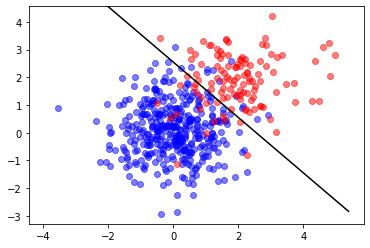

In [3]:
m0 = np.array([0,0])
m1 = np.array([2,2])
K = np.array([[1,0],[0,1]])

N = 500
pi = 1/4
N1 = st.binom.rvs(N,pi)
N0 = N - N1
X0 = st.multivariate_normal.rvs(m0,K,N0) # X for class 0
X1 = st.multivariate_normal.rvs(m1,K,N1) # X for class 1
X = np.concatenate((X0, X1), axis=0)
y = np.concatenate((np.array([0]*N0),np.array([1]*N1)),axis=0)

# begin solution ...
beta = (m1 - m0).T @ la.inv(K)
gamma = np.log(pi/(1-pi)) - (1/2)*(m1 - m0).T @ la.inv(K) @ (m1 + m0)
# end solution

thetaGN = [beta[0],beta[1],gamma] # theta based on the model used to generate data
classPlot([thetaGN])
print('thetaGN = ',thetaGN)

## Maximum Likelihood
(25 pts) Similar to the previous part, we are going to build a binary classifier over the same dataset but this time we will be using ML to estimate the parameters of the generative model from the data. **Add your code below** to find the values of pi, m0, m1 and sigma are all computed from the data and then  construct a classifier.

We then plot the data points and the ML decision line along with the true decision line (obtained in the previous part) in one plot, using the same plot helper function classPlot.

In [4]:
# begin solution Maximum Likelihood Estiamtion ...
pi_ml = sum(y)/len(y)
m0_ml = sum(X[np.where(y==0)])/sum(1-y)
m1_ml = sum(X[np.where(y==1)])/sum(y)
sigma2_ml = (1/N)*(sum((X[np.where(y==0)]-m0_ml)**2) + sum((X[np.where(y==1)]-m1_ml)**2))
K_ml = np.array([[sigma2_ml[0], 0], [0, sigma2_ml[1]]])
print(f'{pi_ml=}\t\t\t\t{pi=}')
print(f'{m0_ml=}\t{m0=}')
print(f'{m1_ml=}\t{m1=}')
print(f'{K_ml=}\n{K=}')
# end solution

pi_ml=0.234				pi=0.25
m0_ml=array([0.00192374, 0.10242545])	m0=array([0, 0])
m1_ml=array([1.98269946, 1.89404756])	m1=array([2, 2])
K_ml=array([[0.94208416, 0.        ],
       [0.        , 0.93292457]])
K=array([[1, 0],
       [0, 1]])


thetaML =  [2.102546453488132, 1.9204361843405169, -5.1892917981985445]


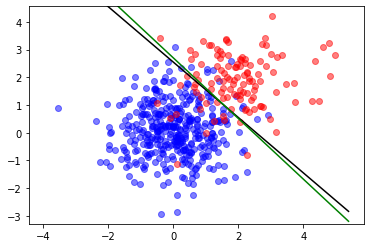

In [5]:
# begin solution Classifier based on ML estimates ...
betaML = (m1_ml - m0_ml) @ la.inv(K_ml)
gammaML = np.log(pi_ml/(1-pi_ml)) + (-1/2)*(m1_ml - m0_ml).T @ la.inv(K_ml) @ (m1_ml + m0_ml)

# end solution 
thetaML = [betaML[0],betaML[1],gammaML] # theta based on maximum likelihood
print('thetaML = ',thetaML)
classPlot([thetaGN,thetaML])

## Gradient Descent for Logistic Regression
(25 pts) Let us assume a logistic regression model. First, we modify the existing data points from the previous parts by concatanting a 1 to each data point (so each data point is of the form x = [x0,x1,1]).

**Implement** gradient descent to find the optimized values for theta with 1000 iterations with a step size equal to $0.001$ to build the classifier.

Similar to the previous part we plot this classifier generated using Gradient descent along with the other two classifiers in a single plot.

[ 1.99275185  1.68245966 -4.77291022]


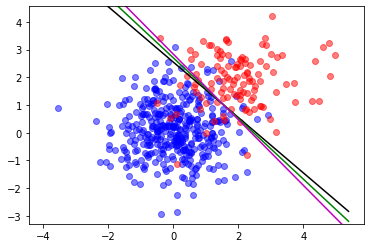

In [6]:
T = 1000
ones = np.array([1]*len(X))[:,None] # column vector consisting of 1s
X_ = np.concatenate((X,ones),axis=1)
theta = np.zeros((T,3))
theta[0] = [0,0,0]
rho = 0.001

# begin solution ...
def h(x, theta):
    return 1/(1 + np.exp(-theta.T @ x))
              
def grad(theta):
    return sum((y[i] - h(x, theta)) * x for i, x in enumerate(X_))

thetaGD = theta[0]
for t in range(1,T):
    thetaGD = thetaGD + rho*grad(thetaGD)
    theta[t] = thetaGD

# end solution
print(thetaGD)
classPlot([thetaGN,thetaML,thetaGD])

## Stochastic Gradient Descent for Logistic Regression
(25 pts) In this part, replace the Gardient Descent from the previous part with a Stochastic Gradient Descent using a step size of $t^{-3/4}$ and 1000 iterations to obtain the optimised value of theta. We then Plot the classifier so obtained along with the previously computed classfiers using the helper function classPlot.

[ 0.90227309  0.92480597 -2.29134642]


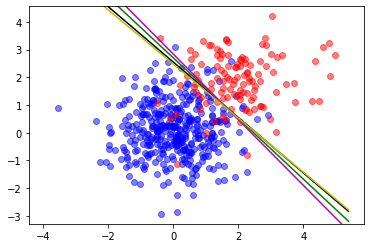

In [7]:
T = 1000
theta = np.zeros((T,3))
theta[0] = [0,0,0]
# begin solution

def single_grad(i, theta):
    return (y[i]-h(X_[i], theta))*X_[i]

thetaSGD = theta[0]
for t in range(1,T):
    i = np.random.randint(0, len(X_))
    thetaSGD = thetaSGD + t**(-3/4)*single_grad(i, thetaSGD)
    theta[t] = thetaSGD

# end solution
print(thetaSGD)
classPlot([thetaGN,thetaML,thetaGD,thetaSGD])